<a href="https://colab.research.google.com/github/AhmedBorch/Optimization/blob/main/Practical_2_optimisation_Pose_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from scipy.optimize import minimize

# Practical 2 Numerical Method

## EXERCISE 1


Check the KKT condition for the following problem, and solve it.

\begin{align}
    \min f(x) &= (x_1-1)^2 + x_2 - 2\\
    \mbox{with } h(x)&= x_2-x_1-1=0 \\
    \mbox{and } c(x)&=x_1+x_2-4 \leq 0
\end{align}




## Exercise 2
### Pose Estimation Simulator

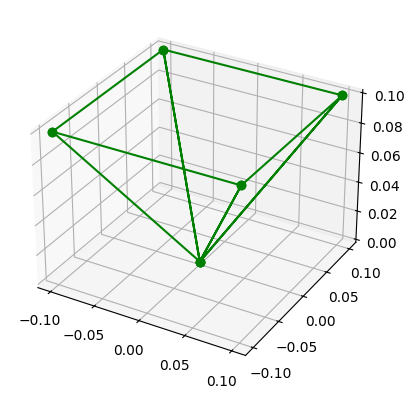

In [ ]:
from scipy.spatial.transform import Rotation as R
import numpy as np
from pylab import *

# Camera 3Dy
def cameraPoints(scale) :
  cC1 = np.array([[0,0,0,1]])
  cC2 = np.array([[-scale,-scale,scale,1]])
  cC3 = np.array([[scale,-scale,scale,1]])
  cC4 = np.array([[scale,scale,scale,1]])
  cC5 = np.array( [[-scale,scale,scale,1]])
  cCs = np.concatenate((cC1,cC2,cC3,cC1,cC3, cC4,cC1,cC4,cC5,cC1,cC5,cC2))
  return(cCs)

cCs = cameraPoints(0.1)
figure(2)
ax = axes(projection='3d')
ax.plot3D(cCs[:,0], cCs[:,1], cCs[:,2],'go-')



# Design of 3D targets

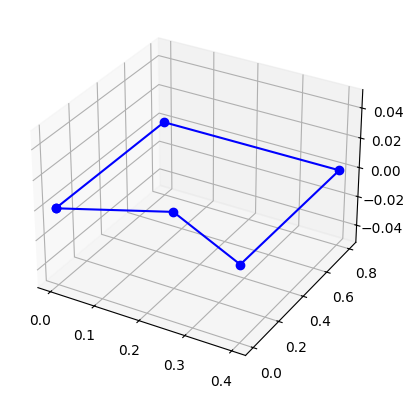

In [ ]:
# 3D targets design

def planar5points(scale=1):
  oX1 = np.array([[0,0,0,1]])
  oX2 = np.array([[0,2*scale,0,1]])
  oX3 = np.array([[1*scale,2*scale,0,1]])
  oX4 = np.array([[1*scale,0,0,1]])
  oX5 = np.array( [[0.5*scale,0.5*scale,0,1]])
  oXs = np.concatenate((oX1,oX2,oX3,oX4,oX5, oX1))
  return oXs

def planar3points(scale=1):
  oX1 = np.array([[0,0,0,1]])
  oX2 = np.array([[0,2*scale,0,1]])
  oX3 = np.array([[1*scale,2*scale,0,1]])
  oXs = np.concatenate((oX1,oX2,oX3, oX1))
  return oXs

def nonplanar4points(scale=1):
  oX1 = np.array([[0,0,0,1]])
  oX2 = np.array([[0,2*scale,0,1]])
  oX3 = np.array([[1*scale,2*scale,0,1]])
  oX4 = np.array([[1*scale,2*scale,1*scale,1]])
  oXs = np.concatenate((oX1,oX2,oX3,oX4,oX1))
  return oXs


oXs = planar5points(0.4)

figure(1)
ax = axes(projection='3d')
#ax.scatter3D(cXs[:,0], cXs[:,1], cXs[:,2]);
ax.plot3D(oXs[:,0], oXs[:,1], oXs[:,2],'bo-')




#Transformation matrix

Here we define the functions to build Homogeneous Matrices that represents the transormation from one frame ${F}_o$ to another frame ${F}_c$
$$^cM_o=\begin{bmatrix}^cR_o &^cT_o\\
0_{3 \times 3} &1
\end{bmatrix}$$

Where  $^cR_o$ is a rotation matrix that represents the rotation from one frame ${F}_o$ to another frame ${F}_c$ and $^cT_o$ is a translation vector that represents the rotation from one frame ${F}_o$ to another frame ${F}_c$



In [ ]:
def rotXYZ(rx,ry,rz, degrees =True):
    if(degrees):
        rx *= np.pi/180
        ry *= np.pi/180
        rz *= np.pi/180
    rotx = np.array([[1,0,0],
                     [0,np.cos(rx),-np.sin(rx)],
                     [0,np.sin(rx),np.cos(rx)]])

    roty = np.array([[np.cos(ry),0,np.sin(ry)],
                     [0,1,0],
                     [-np.sin(ry),0, np.cos(ry)]])

    rotz = np.array([[np.cos(rz),-np.sin(rz),0],
                     [np.sin(rz),np.cos(rz),0],
                     [0,0,1]])
    rotxyz = rotx.dot(roty.dot(rotz))
    #print('r',rotxyz)
    rotxyz = np.round (rotxyz,15)
    #print('round',rotxyz)
    return rotxyz

def isRot (M, dec):
    tag = False
    I= np.identity(M.shape[0])

    print('cond1 M.MT=I',np.round (np.matmul(M, M.T)),dec)
    print('cond2 np.linalg.det(M)',np.round(np.linalg.det(M),dec))
    if (np.all(np.round( (np.matmul(M, M.T)),10) == I) and (np.round(np.linalg.det(M),dec)==1)):
        tag = True

    return tag


# define the transformations from one frame c to frameo
def homogeneousMatrix(tx,ty,tz,rx,ry,rz):
    cRo = rotXYZ(rx,ry,rz, degrees =True)
    cTo = np.array([[tx,ty,tz]])
    M = np.concatenate(
        (np.concatenate((cRo,cTo.T), axis=1),
         np.array([[0,0,0,1]])),axis=0 )
    return M

# change frame of a list of 3D points
# for each point cX=cMo*oX
def changeFrame(oXs,cMo) :
  cXs = []
  for oX in oXs :
    cX =  cMo.dot(oX.T)
    cXs.append(cX)
  cXs = np.array(cXs)
  return cXs






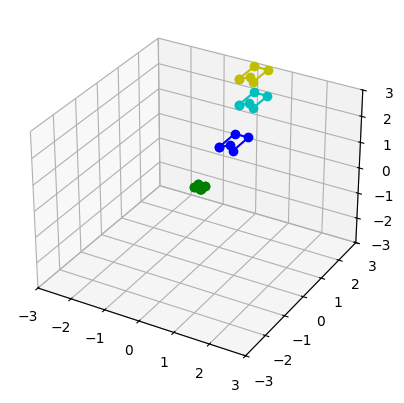

In [ ]:
# Display the relative object/camera motion wrt the camera frame
# let us call c1 the first camera position, c2 the second and c2 the third

# first camera/objet position
c1Mo = homogeneousMatrix(0,1,1,0,0,0)
# second camera/objet position
c2Mo = homogeneousMatrix(0,2,2,0.0,0,0)
# third camera/objet position
c3Mo = homogeneousMatrix(0,2,3,0,0,0)


figure(1)
ax = axes(projection='3d')
ax.set_xlim3d(-3, 3)
ax.set_ylim3d(-3,3)
ax.set_zlim3d(-3,3)
#ax.scatter3D(cXs[:,0], cXs[:,1], cXs[:,2]);

ax.plot3D(cCs[:,0], cCs[:,1], cCs[:,2],'go-')

cXs = changeFrame(oXs,c1Mo)
ax.plot3D(cXs[:,0], cXs[:,1], cXs[:,2],'bo-')

cMo = c2Mo
cXs = changeFrame(oXs,cMo)
ax.plot3D(cXs[:,0], cXs[:,1], cXs[:,2],'co-')

cMo = c3Mo
cXs = changeFrame(oXs,cMo)
ax.plot3D(cXs[:,0], cXs[:,1], cXs[:,2],'yo-')

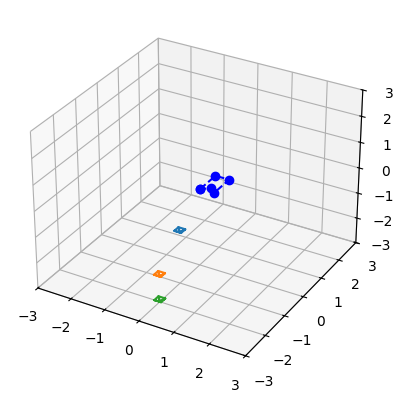

In [ ]:
# Display the cameras position in the fixed object frame

from scipy import linalg

figure(3)
ax = axes(projection='3d')
ax.set_xlim3d(-3, 3)
ax.set_ylim3d(-3,3)
ax.set_zlim3d(-3,3)
ax.plot3D(oXs[:,0], oXs[:,1], oXs[:,2],'bo--')

cMo = c1Mo
oMc = linalg.inv(cMo)
oCs = changeFrame(cCs,oMc)
ax.plot3D(oCs[:,0], oCs[:,1], oCs[:,2])

cMo = c2Mo
oMc = linalg.inv(cMo)
oCs = changeFrame(cCs,oMc)
ax.plot3D(oCs[:,0], oCs[:,1], oCs[:,2])

cMo = c3Mo
oMc = linalg.inv(cMo)
oCs = changeFrame(cCs,oMc)
ax.plot3D(oCs[:,0], oCs[:,1], oCs[:,2])


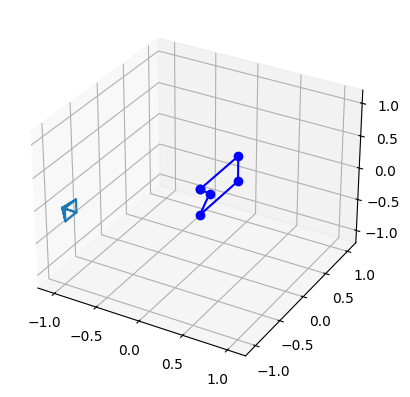

In [ ]:
wMo = homogeneousMatrix(0,0,0,0,90,0)
wXs = changeFrame(oXs,wMo)

figure(3)
ax = axes(projection='3d')
ax.set_xlim3d(-1.2, 1.2)
ax.set_ylim3d(-1.2,1.2)
ax.set_zlim3d(-1.2,1.2)
ax.plot3D(wXs[:,0], wXs[:,1], wXs[:,2],'bo-')

cMo =c1Mo
oMc = linalg.inv(cMo)
oCs = changeFrame(cCs,oMc)
wCs = changeFrame(oCs,wMo)
ax.plot3D(wCs[:,0], wCs[:,1], wCs[:,2])

cMo = c2Mo
oMc = linalg.inv(cMo)
oCs = changeFrame(cCs,oMc)
wCs = changeFrame(oCs,wMo)
ax.plot3D(wCs[:,0], wCs[:,1], wCs[:,2])

cMo = c3Mo
oMc = linalg.inv(cMo)
oCs = changeFrame(cCs,oMc)
wCs = changeFrame(oCs,wMo)
ax.plot3D(wCs[:,0], wCs[:,1], wCs[:,2])



# Pinhole perspective model

Define the perspective projection $\mathbf{x}(x,y,1)$ of the 3D points $\mathbf{^cX}(X,Y,Z,1)$ assuming the focal f=1

$$\mathbf{x_m}=\mathbf{P} \mathbf{^cX}$$

where $\mathbf{x_m}$ is the point coordinates in meter
and $\mathbf{P}$ is the projection matrix such that

$$\mathbf{P} = \begin{bmatrix}
1 & 0 & 0&0 \\
0& 1 & 0&0\\
0&0&1&0
\end{bmatrix}$$

If we want to obtain the point in pixels, we have to had another transform

$$\mathbf{x_p}=\mathbf{K}\mathbf{x_m}$$

with $\mathbf{K}$ the camera calibration matrix

$$\mathbf{K}=\begin{bmatrix}
l_x & 0 & u_0 \\
0& l_y & v_0\\
0&0&1
\end{bmatrix}$$

with $l_x$ and $l_y$ are an expression of the focal length in pixel and $u_0$ and $v_0$ are the coordinates of the principal point in pixels.

**WARNING : before projection, the 3D point have to be expressed in the camera frame, this leads to the global equation**

$$\mathbf{x_p}=\mathbf{K}\mathbf{P} ^c\mathbf{M}_o\mathbf{^oX}$$


**Here we will consider the point to be in meter, then K = identity(3,3) = I and f=1**


In [ ]:
# simplify pinhole modele assuming f=1
def pinholeProj(cXs) :
    # WARNING : before projection the point have to be expressed in the camera frame
    xs = []
    for X in cXs:
        f = 1
        print(X)
        x = f*X[0]/X[2]
        y = f*X[1]/X[2]
        point = np.array([x,y,1])
        xs.append(point)
    return(np.array(xs))




[0. 1. 1. 1.]
[0.  1.8 1.  1. ]
[0.4 1.8 1.  1. ]
[0.4 1.  1.  1. ]
[0.2 1.2 1.  1. ]
[0. 1. 1. 1.]
[0. 2. 3. 1.]
[0.  2.8 3.  1. ]
[0.4 2.8 3.  1. ]
[0.4 2.  3.  1. ]
[0.2 2.2 3.  1. ]
[0. 2. 3. 1.]
[0. 2. 3. 1.]
[0.  2.8 3.  1. ]
[0.4 2.8 3.  1. ]
[0.4 2.  3.  1. ]
[0.2 2.2 3.  1. ]
[0. 2. 3. 1.]


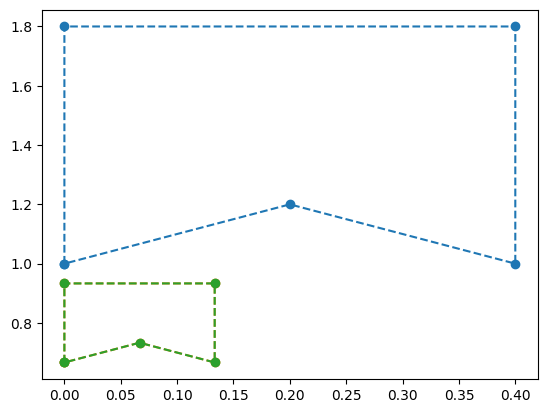

In [ ]:
# Test the projection and display it

c1Xs = changeFrame(oXs,c1Mo)
c1xs = pinholeProj(c1Xs)
figure(3)
plot(c1xs[:,0],c1xs[:,1],'o--')

c2Xs = changeFrame(oXs,c2Mo)
c2xs = pinholeProj(cXs)
plot(c2xs[:,0],c2xs[:,1],'o--')

c3Xs = changeFrame(oXs,c3Mo)
c3xs = pinholeProj(c3Xs)
plot(c3xs[:,0],c3xs[:,1],'o--')

# Method to estimate a pose from 3 points

Let us assume that we know 3 points and that their coordinates are known in meter

$$\mathbf{q}_1 = (x_1,y_1,1)^T$$

$$\mathbf{q}_2 = (x_3,y_3,1)^T$$

$$\mathbf{q}_3 = (x_3,y_3,1)^T$$

The method consists in two step : first determine the 3 3D points $\mathbf{Q}$ relative to the three 2D points $\mathbf{q}$ and then compute the pose.

Here we will get interested into the distance between those three  3Dpoints.
Let us call them $d_{12}$, $d_{13}$, $d_{23}$, assumed to be known.

First, let us look for the 3 points $\mathbf{Q}_1$, $\mathbf{Q}_2$ and $\mathbf{Q}_3$ that projects on the three points $\mathbf{q}_1$, $\mathbf{q}_2$ and $\mathbf{q}_3$.

We have the following equations

\begin{equation}
dist({\mathbf{Q}}_i,\mathbf{Q}_j)=d_{ij} \forall i,j \in {1,2,3}
\end{equation}
and
\begin{equation}
\mathbf{P}\mathbf{Q}_i=q_i  \forall i \in {1,2,3}
\end{equation}

We assume that the points are expressed in meter directly so

$$\mathbf{P} = \begin{bmatrix}
1 & 0 & 0&0 \\
0& 1 & 0&0\\
0&0&1&0
\end{bmatrix}$$

The 3D coordinates of $\mathbf{Q}_i$ is on a 3D line going through the center of the camera and the 2D point $\mathbf{q}_i$, which can be expressed as

\begin{equation}
\mathbf{Q}_i= \begin{pmatrix}
\lambda_i\mathbf{q}_i \\
1
\end{pmatrix}  \forall i \in {1,2,3}
\end{equation}

Then the parameters to find are the three parameters $\lambda_1$, $\lambda_2$, and $\lambda_3$.

The problem consists in findings those $\lambda_i$ for which
\begin{equation}
dist({\mathbf{Q}}_i,\mathbf{Q}_j)=d_{ij} \forall i,j \in {1,2,3}
\end{equation}


We can rewrite :  
\begin{equation}
\mathbf{Q}_i= \begin{pmatrix}
X_i \\
Y_i\\
Z_i\\
1
\end{pmatrix}  = \begin{pmatrix}
\lambda_i\mathbf{x}_i \\
\lambda_i\mathbf{y}_i \\
\lambda_i\\
1
\end{pmatrix} \forall i \in {1,2,3}
\end{equation}

If we develop the distance formula
\begin{equation}
dist({\mathbf{Q}}_i,\mathbf{Q}_j)= \sqrt{(X_i-X_j)^2+(Y_i-Y_j)^2+(Z_i- Z_j)^2}  \forall i,j \in {1,2,3}
\end{equation}

And then
\begin{equation}
dist({\mathbf{Q}}_i,\mathbf{Q}_j)= \sqrt{(\lambda_i x_i-\lambda_j x_j)^2+(\lambda_i y_i-\lambda_j y_j)^2+(\lambda_i-\lambda_j)^2}  \forall i,j \in {1,2,3}
\end{equation}

we can skip the square root and write the three equation of the problem:
\begin{equation}
 {(\lambda_i x_i-\lambda_j x_j)^2+(\lambda_i y_i-\lambda_j y_j)^2+(\lambda_i-\lambda_j)^2} =d_{ij}^2 \forall i,j \in {1,2,3}
\end{equation}


Then we have three equations and 3 unknowns then we should have a finite number of solutions. Yet, we have 3 quadratic equation then we will have 8 solutions (including complex numbers and solution where $Z<0$ which we can easily discarded)







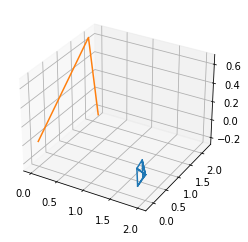

In [ ]:
# define 3 3D points in the object frame
oQ1 = np.array([[0,0,0,1]])
oQ2 = np.array([[0,2,0,1]])
oQ3 = np.array([[1,2,0,1]])
oQs = np.concatenate((oQ1,oQ2,oQ3))

# define the position of the object in the world frame
wMo = homogeneousMatrix(0,0,0,10,90,10)

# express the points in the world frame
wQs = changeFrame(oQs,wMo)

# define camera just for display
cCs = cameraPoints(0.1)

# define the position of the camera in the world reference frame
wMc = homogeneousMatrix(2,0,0,10,-90,0)
wCs = changeFrame(cCs,wMc)

#plot the points and camera
figure(4)
ax = axes(projection='3d')
ax.plot3D(wCs[:,0], wCs[:,1], wCs[:,2])
ax.plot3D(wQs[:,0], wQs[:,1], wQs[:,2])







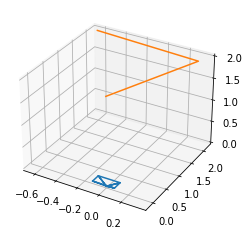

In [ ]:
# Define the camera/object transformation to express the points in the camera frame
cMo = linalg.inv(wMc)@wMo

#define the point in the camera frame
cQs = changeFrame(oQs,cMo)

# diplay all in the camera frame
figure(5)
ax = axes(projection='3d')
ax.plot3D(cCs[:,0], cCs[:,1], cCs[:,2])
ax.plot3D(cQs[:,0], cQs[:,1], cQs[:,2])



[0. 0. 2. 1.]
[0.34729636 1.96961551 2.         1.        ]
[-0.6375114   2.14326368  2.          1.        ]


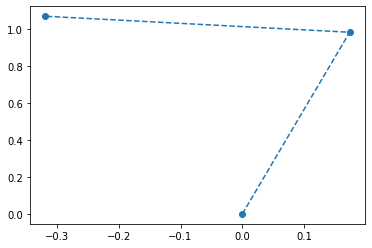

In [ ]:
# now project the points
qs = pinholeProj(cQs)
plot(qs[:,0],qs[:,1],'o--')

# Questions

1. Compute their 3D distance $dij$, and save it in an array $d$
2. Select a set of $\lambda_0$ and save it in a vector $\lambda$s
3. Build a cost fonction that takes as input $\lambda$s, the distances $d$ and the 2D points $\mathbf{q}_i$
4. use the function minimise to find the argmin value, $\lambda$s
5. use  $\lambda$s to find $\mathbf{Q}_i$ (check if you find back your simulated points)
6. In order to find easily the solution, it is better to choose 4 points. Modify the method to find 4 points



# Method to find the registration between two sets of points

## method 1

1. Find the centroid of the two sets
2. Shift the data to get R
3. Find t

### Find the centroid

$$P_c = \frac{1}{N} \sum_{1}^{N}P_i $$


### Shift the points

$$^oP' = {^oP} - {^oP_c}$$
$$^cP' = {^cP} - {^cP_c}$$

### Find R

Compute the covariance matrix H, it has to be 3x3. Pay close attention to the transpose symbol. It’s doing a multiplication between 2 matrices where the dimensions effectively are, 3xN and Nx3, respectively.
$$H_{3\times3} = {^oP'}{^cP'}^T$$

Make SVD decomposition of H

$$[U,S,V] = SVD(H)$$

```
   U, S, Vt = np.linalg.svd(H)
```

$$R=VU^T$$

There’s a special case when finding the rotation matrix that you have to take care of. Sometimes the SVD will return a ‘reflection’ matrix, which is numerically correct but is actually nonsense in real life. This is addressed by checking the determinant of R (from SVD above) and seeing if it’s negative (-1). If it is then the 3rd column of V is multiplied by -1.

```
if determinant(R) < 0
    [U,S,V] = svd(R)
    multiply 3rd column of V by -1
    R = V * transpose(U)
end if

```

### Find t

$$t = {^cP_c} - R\times{^oP_c}$$

### Ref
https://en.wikipedia.org/wiki/Kabsch_algorithm


# Dementhon method to compute pose from a set of 3D points

*   Élément de liste
*   Élément de liste



Let $Q_i = (^oX_i,^oY_i,^oZ_i,1)$ be a set of 3D points and $q_i=(x_i,y_i)$ is projection

1. find the center of gravity of the point $Q_i$ in the object frame, store it as $Q_0$
3. translate all the 3D point wrt to center of gravity $Q'_i=Q_i-Q_0+[0,0,0,1]^T$ so that the center of gravity is the center of the object.


The coordinates of these points in the camera frame obtained by perspective projection of these points in the
image plane are given by

$$x_i=\frac{^cX_i}{^cZ_i}$$

$$y_i=\frac{^cY_i}{^cZ_i}$$

Knowing the position of the camera in the object frame $^cM_o$ , we have:
$$x_i = \frac{r_{11} ^oX_i + r_{12}^oY_i + r_{13}^oZ_i + t_x}{r_{31} ^oX_i + r_{32} ^o Y_i + r_{33} ^oZ_i + t_z}$$


$$y_i =\frac{ r_{21} ^oX_i + r_{22} ^oY_i + r_{23} ^oZ_i + t_y}{
r_{31} ^oX_i + r_{32} ^o Y_i + r_{33} ^oZ_i + t_z} $$

Let us pose:
$$I^T = \frac{1}{t_z}\begin{bmatrix}r_{11} & r_{12}& r_{13}& t_{x}\end{bmatrix}$$
$$J^T = \frac{1}{t_z}\begin{bmatrix}r_{21} & r_{22}& r_{23}& t_{y}\end{bmatrix}$$

$$\epsilon_i = \frac{1}{t_z}(r_{31} ^oX_i+r_{31} ^oY_i+r_{33} ^oZ_i)$$

We can then write

$$x_i(\epsilon_i+1) = \begin{bmatrix}^oX_i &^oY_i  &^oZ_i \end{bmatrix} I$$

$$y_i(\epsilon_i+1) = \begin{bmatrix}^oX_i &^oY_i  &^oZ_i \end{bmatrix} J$$


Let us call $A =  \begin{bmatrix}^oX_i &^oY_i  &^oZ_i \end{bmatrix}$, $B_1=x_i(\epsilon_i+1) $ and  $B_2=y_i(\epsilon_i+1) $ and we have the system

$$B1=AI$$
$$B2=AJ$$

Let us note

$$I^* = \frac{1}{t_z}\begin{bmatrix}r_{11} & r_{12}& r_{13}\end{bmatrix}$$
$$J^* = \frac{1}{t_z}\begin{bmatrix}r_{21} & r_{22}& r_{23}\end{bmatrix}$$


![picture](https://drive.google.com/uc?export=view&id=1oBKCg3cZB9lsLeKeQFEXI0HuFI0af-YM)



# OPEN CV PNP

Study and test PNP method of open CV

# More exercises to practice numerical methods

**Exercice**

Same with
$$\left\{ \begin{eqnarray} min f(x_1,x_2)&=x_1^2+x_2^2-x_1x_2+x_2\\x+2y&=1\end{eqnarray}\right. $$

**Exercice**

Minimize
$F(x, y) = x^2 − 14x + y^2 − 6y − 7$
on $C=\{(x,y)\in\mathbb{R}^2;x+y\leq2 \text{ et} x+2y\leq 3\}$.
Give a geometrical interpretation

**Exercise**

A company manufactures two models of small cars, models X and Y. Model X, the most affordable, sells for 1 euro each. Model Y, which is much more sophisticated, sells for 3 euros. The manufacturing cost, expressed in euros, is given by the following function:
$C(x, y) = 5x^2 + 5y^2 - 2xy - 2x - 1000$.
where $x$ is the number of small cars of model $X$ and $y$ is the number of small cars of model model $Y$. It is assumed that all the toys manufactured are sold on the market.

Throughout the exercise, we will note $C_+ = (\mathbb{R}^∗_+)^2$.
1. Let $(x, y)$ be $\in C_+$. Determine the profit $P(x, y)$ made by the firm when it sold
$x$ toys of model $X$ and $y$ toys of model $Y$.
2. Study the convexity of the function P on $C_+$.
3. The production capacity of the firm is a total of 20 toys per day. Assuming
that the firm is operating at full capacity, find the optimal distribution between models
of type X and Y that maximizes daily profit. Calculate the profit in this case.
realized in this case.
Hint: in this question and the next one, we will not take into account the (yet natural) constraints
natural) "$x ≥ 0$" and "$y ≥ 0$". We will explain why this does not actually change anything.
4. The company's board of directors questions the relevance of wanting to produce at full capacity. It wonders whether it can increase the profit by producing
by producing differently. Can you help the board of directors?

#References
in french http://crowley-coutaz.fr/jlc/Courses/2008/GVR.VO/GVR-S6-sturm.pdf

in english https://haralick.org/conferences/Analysis_and_Solutions_Perspective.pdf

in english https://trace.tennessee.edu/cgi/viewcontent.cgi?article=2920&context=utk_gradthes

in english http://www.daniel.umiacs.io/daniel_papersfordownload/Pose25Lines.pdf

in english https://visp-doc.inria.fr/manual/visp-tutorial-computer-vision.pdf

in english https://www.robots.ox.ac.uk/~az/tutorials/tutoriala.pdf

in english http://www.r-5.org/files/books/computers/algo-list/image-processing/vision/Richard_Hartley_Andrew_Zisserman-Multiple_View_Geometry_in_Computer_Vision-EN.pdf*


in english https://hal.inria.fr/inria-00590105/document

in english https://my.eng.utah.edu/~cs6320/cv_files/Lecture3.pdf
